# Section 3.2: Covariance distance estimation

This page contains simulations in Section 3.2: estimation of various distance between covariance matrices in large dimension

## Contents

    - Visualization of behavior of $x \mapsto x m_\mu(x)$
    - Classical versus random matrix improved covariance distance estimator
    - FUNCTIONS

## Visualization of behavior of $x \mapsto x m_\mu(x)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
pi = np.pi

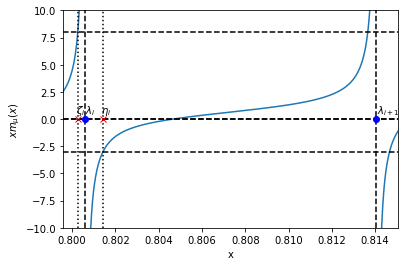

In [85]:
coeff = 3
p = 100*coeff
n1 = 300*coeff
n2 = 900*coeff

c1 = p/n1
c2 = p/n2

np.random.seed(928)
Z1 = np.random.randn(p,n1)
Z2 = np.random.randn(p,n2)

eig_C1 = [1,2,4]
eig_C2 = [1,3,5]
C1 = np.diag(np.concatenate([eig_C1[0]*np.ones(p//3),eig_C1[1]*np.ones(p//3),eig_C1[2]*np.ones(p//3)]))
C2 = np.diag(np.concatenate([eig_C2[0]*np.ones(p//3),eig_C2[1]*np.ones(p//3),eig_C2[2]*np.ones(p//3)]))

X1 = scipy.linalg.sqrtm(C1)@Z1
X2 = scipy.linalg.sqrtm(C2)@Z2

SCM1 = X1@(X1.T)/n1
SCM2 = X2@(X2.T)/n2

SCM = np.linalg.solve(SCM1,SCM2)
eigs_SCM = np.sort(np.linalg.eigh(SCM)[0])

m   = lambda x : np.sum(1/(eigs_SCM-x))/p
x_m = lambda x : x*m(x)

tol1 = 1e-3
index_eigs_SCM = 50
zoom_eigs_SCM  = np.linspace(eigs_SCM[index_eigs_SCM-1]-tol1,eigs_SCM[index_eigs_SCM]+tol1,1000)

tol2 = 1e-4
zoom_eigs_SCM[(zoom_eigs_SCM<=eigs_SCM[index_eigs_SCM-1]+tol2)*(zoom_eigs_SCM>=eigs_SCM[index_eigs_SCM-1]-tol2)]=np.nan
zoom_eigs_SCM[(zoom_eigs_SCM<=eigs_SCM[index_eigs_SCM]+tol2)*(zoom_eigs_SCM>=eigs_SCM[index_eigs_SCM]-tol2)]=np.nan

# numerical evaluation of eta and zeta
eta  = np.linalg.eigh(np.diag(eigs_SCM) + np.sqrt(eigs_SCM).reshape(p,1)@np.sqrt(eigs_SCM).reshape(1,p)/(n1-p))[0]
eta  = eta[(eta<eigs_SCM[index_eigs_SCM])*(eta>eigs_SCM[index_eigs_SCM-1])]
zeta = np.linalg.eigh(np.diag(eigs_SCM) - np.sqrt(eigs_SCM).reshape(p,1)@np.sqrt(eigs_SCM).reshape(1,p)/n2)[0]
zeta = zeta[(zeta<eigs_SCM[index_eigs_SCM-1])*(zeta>eigs_SCM[index_eigs_SCM-2])]

plt.plot(zoom_eigs_SCM, [x_m(x) for x in zoom_eigs_SCM])
plt.axvline(x=eigs_SCM[index_eigs_SCM-1],ls='--',c='k')
plt.axvline(x=eigs_SCM[index_eigs_SCM],ls='--',c='k')
plt.axhline(y=0,ls='--',c='k')
plt.axhline(y=(1-c2)/c2,ls='--',c='k')
plt.axhline(y=-1/c1,ls='--',c='k')
plt.axhline(y=0,ls='--',c='k')
plt.gca().set_xlim([eigs_SCM[index_eigs_SCM-1]-tol1,eigs_SCM[index_eigs_SCM]+tol1])
plt.gca().set_ylim([-10,10])

plt.xlabel(r'x')
plt.ylabel(r'$x m_{\mu}(x)$')
plt.plot(eigs_SCM[index_eigs_SCM-1],0,'ob')
plt.text(eigs_SCM[index_eigs_SCM-1]+1e-5,.5,r'$\lambda_i$')
plt.plot(eigs_SCM[index_eigs_SCM],0,'ob')
plt.text(eigs_SCM[index_eigs_SCM]+1e-5,.5,r'$\lambda_{i+1}$')

plt.plot(eta, 0,'xr')
plt.plot(zeta, 0,'xr')
plt.text(eta-1e-4, .5,r'$\eta_i$')
plt.text(zeta-1e-4, .5,r'$\zeta_i$')
plt.axvline(x=eta,ls=':',c='k')
plt.axvline(x=zeta,ls=':',c='k')
_ = plt.show()

## Classical versus random matrix improved covariance distance estimator

In [197]:
p_loop = [2**(i+1) for i in range(9)]
n1 = 1024
n2 = 2048

distance = 'Fisher'

if distance == 'Fisher':
    f = lambda t : np.log(t)**2

if distance == 'bhattacharrya':
    f = lambda t : -1/4*np.log(t)+1/2*np.log(1+t)-1/2*np.log(2)

if distance == 'KL':
    f = lambda t : 1/2*t-1/2*np.log(t)-1/2

if distance == 't':
    f = lambda t : t

if distance == 'log':
    f = lambda t : np.log(t)

if distance == 'log(1+st)':
    s = 1
    f = lambda t : np.log(1+s*t)


np.random.seed(928)
nb_average_loop = 30
store_output = [] # [population distance, RMT estimator, classical estimator]

for p in p_loop:

    C1 = scipy.linalg.toeplitz([.2**i for i in range(p)])
    C2 = scipy.linalg.toeplitz([.4**i for i in range(p)])
    
    C1_half = scipy.linalg.sqrtm(C1)
    C2_half = scipy.linalg.sqrtm(C2)
    
    eigs_C1_over_C2 = np.linalg.eigh(np.linalg.solve(C1,C2))[0]    
    
    tmp = np.zeros(3)
    for j in range(nb_average_loop):
        X1 = C1_half@np.random.randn(p,n1)
        X2 = C2_half@np.random.randn(p,n2)

        RMTDistEst,ClassDistEst = RMTCovDistEst(X1,X2,distance)
        tmp += np.array([np.mean(f(eigs_C1_over_C2)),RMTDistEst,ClassDistEst])/nb_average_loop

    store_output.append(tmp)

print('Performance of different estimators:')
for i in range(len(p_loop)):
    print("{}\t{}\t{}\t{}".format(p_loop[i],store_output[i][0],store_output[i][1],store_output[i][2]))

Performance of different estimators:
2	0.05326170345067875	0.04782348672162983	0.05227355994599705
4	0.0797521113104581	0.07415944557709274	0.08150644268617505
8	0.09278003683653083	0.08973533729114105	0.10282429692922976
16	0.0992942286577156	0.0964304016692845	0.12104619557012583
32	0.10255132458169583	0.10253232482070032	0.1505325767053807
64	0.10417987254368574	0.10374016518792453	0.19977156106934338
128	0.10499414652468095	0.10527601843259853	0.3031556297572515
256	0.10540128351517843	0.10672042380486357	0.5355874443144578
512	0.10560485201042735	0.10892082027417048	1.156286029032899


## FUNCTIONS

Code from https://github.com/maliktiomoko/RMTEstimCovDist

In [201]:
def RMTCovDistEst(X1,X2,distance):
#RMTCovDistEst: random matrix-based improved estimators of distances between covariances
#INPUT: X1 (input data of covriance C1), X2 (input data of covriance C2), distance (different types of distances under consideration)

    n1=np.size(X1,1)
    n2=np.size(X2,1)
    p =np.size(X1,0)

    if distance == 'Fisher':
        f = lambda t : np.log(t)**2
    
    if distance == 'bhattacharrya':
        f = lambda t : -1/4*np.log(t)+1/2*np.log(1+t)-1/2*np.log(2)

    if distance == 'KL':
        f = lambda t : 1/2*t-1/2*np.log(t)-1/2

    if distance == 't':
        f = lambda t : t

    if distance == 'log':
        f = lambda t : np.log(t)
    
    if distance == 'log(1+st)':
        s = 1
        f = lambda t : np.log(1+s*t)

    c2=p/n2
    c1=p/n1
    hatC1=1/n1*(X1@X1.T)
    hatC2=1/n2*(X2@X2.T)

    hatC2_half = scipy.linalg.sqrtm(hatC2)
    F=hatC2_half@np.linalg.inv(hatC1)@hatC2_half.T

    lambda_ =np.sort(np.linalg.eigh(F)[0])
    slambda_=np.sqrt(lambda_)

    eta  = np.sort(np.linalg.eigh(np.diag(lambda_)-slambda_.reshape(p,1)@slambda_.reshape(1,p)/(p-n1))[0])
    zeta = np.sort(np.linalg.eigh(np.diag(lambda_)-slambda_.reshape(p,1)@slambda_.reshape(1,p)/n2)[0])

    m = lambda z : np.mean(1/(lambda_-z))
    phi= lambda z : z+c1*z**2*m(z)
    psi= lambda z : 1-c2-c2*z*m(z)

    if distance == 'Fisher':
        M=np.zeros( (p,p) )
        N=np.zeros( (p,p) )

        for i in range(p):
            M[i,i]=1/(2*lambda_[i]**2)
            N[i,i]=1/lambda_[i]

            js = list(range(p))
            del js[i]
            for j in js:
                M[i,j]=(-1+lambda_[i]/lambda_[j]-np.log(lambda_[i]/lambda_[j]))/(lambda_[i]-lambda_[j])**2
                N[i,j]=np.log(lambda_[i]/lambda_[j])/(lambda_[i]-lambda_[j])

        # Large p-estimate

        RMTDistEst=2*(c1+c2-c1*c2)/(c1*c2)*( (eta-zeta)@M@(eta-lambda_)+(eta-lambda_)@(np.log((1-c1)*lambda_)/lambda_) ) \
                    -2/p*np.sum((eta-zeta)@N)+1/p*np.sum(np.log((1-c1)*lambda_)**2) \
                    -2*(1-c2)/c2*( 1/2*np.log( (1-c1)*(1-c2) )**2+(eta-zeta)@(np.log((1-c1)*lambda_)/lambda_) )

        ClassDistEst=np.mean(f(lambda_))
    
    if distance == 'log(1+st)':
        # additional kappa term in negative side
        s=1
        kappa_p=0
        kappa_m=-1/(s*(1-c1))

        if c2>1:
            kappa_p=np.min(lambda_[lambda_>1e-3])        
            while phi(kappa_m)/psi(kappa_m)>-1/s:
                kappa_m=2*kappa_m

        while np.abs(kappa_p-kappa_m)>1e-6*np.abs(eta(p)-zeta(p)):
            kappa_=(kappa_p+kappa_m)/2
            if phi(kappa_)/psi(kappa_)<-1/s:
                kappa_m=kappa_
            else:
                kappa_p=kappa_

        kappa_0=(kappa_p+kappa_m)/2
        
        RMTDistEst=(c1+c2-c1*c2)/(c1*c2)*np.log((c1+c2-c1*c2)/(1-c1)/np.abs(c2-s*c1*kappa_0))+1/c2*np.log(np.abs(-s*kappa_0*(1-c1)))+1/p*np.sum(np.log(np.abs(1-lambda_/kappa_0)))
        ClassDistEst=mean(f(lambda_))

    if distance == 'bhattacharrya':
        RMTDistEst=(-1/4)*RMTCovDistEst(X,Y,'log')+1/2*RMTCovDistEst(X,Y,'log(1+st)')-1/2*np.log(2)
        ClassDistEst=mean(f(lambda_))

    if distance == 'KL':
        RMTDistEst=1/2*((1-c1)*np.mean(lambda_)-np.mean(np.log(lambda_))+(1-c1)/c1*np.log(1-c1)-(1-c2)/c2*np.log(1-c2)-1)
        ClassDistEst=mean(f(lambda_))

    if distance == 't':
        RMTDistEst=(1-c1)*np.mean(lambda_)
        ClassDistEst=np.mean(f(lambda_))

    if distance == 'log':
        RMTDistEst=1/p*np.sum(np.log(lambda_))-(1-c1)/c1*np.log(1-c1)+(1-c2)/c2*np.log(1-c2)
        ClassDistEst=np.mean(f(lambda_))

    if distance == 'Wasserstein':
        RMTDistEst,ClassDistEst=RMTWassDist(X1,X2)
        
    return RMTDistEst,ClassDistEst


def RMTWassDist(X1,X2):
#Function that compute the Wasserstein distance between Gaussian centered
#distribution based on the article Random  Matrix-Improved  Estimation  of  the  Wasserstein  Distance
#between  two  Centered  Gaussian  Distribution (Malik TIOMOKO & Romain COUILLET)
#Input samples from the first class X1 of dimension p*n1 and the
#samples from the second class X2 of size p*n2

    p=np.size(X1,0)
    n1=np.size(X1,1)
    n2=np.size(X2,1)
    c1=p/n1
    c2=p/n2

    #Sample covariance estimate
    hatC1=X1@X1.T/n1
    hatC2=X2@X2.T/n2
    lambda_=np.sort(np.real(np.linalg.eig(hatC1@hatC2)[0]))

    m= lambda z : np.mean(1/(lambda_-z))
    phi= lambda z : z/(1-c1-c1*z*m(z))
    psi= lambda z : 1-c2-c2*z*m(z)
    f= lambda z : np.sqrt(z)

    eta =np.sort(np.linalg.eigh(np.diag(lambda_)-(1/n1)*np.sqrt(lambda_).reshape(p,1)@np.sqrt(lambda_).reshape(1,p))[0])
    zeta=np.sort(np.linalg.eigh(np.diag(lambda_)-(1/n2)*np.sqrt(lambda_).reshape(p,1)@np.sqrt(lambda_).reshape(1,p))[0])
    
    # Distinguish the case n1=n2 vesus n1!=n2
    if n1==n2:
        RMTDistEst=(1/p)*np.trace(hatC1+hatC2)-2*(np.sum(np.sqrt(lambda_))-np.sum(np.sqrt(zeta)))*(2*n1/p)
    else:
        # Distinguish the case where n1<n2 to the case where n1>n2
        if eta[0]<zeta[0]:
            my_eta=zeta
            my_zeta=eta
        else:
            my_zeta=zeta
            my_eta=eta
        
        other= lambda z : 2*np.sum(1/(z-zeta))-2*np.sum(1/(z-lambda_))

        integrand_real= lambda z : 1/(2*pi)*2*f(-(phi(z)/psi(z)))*other(z)*(psi(z)/c2)

        # Computing the second term (real_integral)
        real_integral=0
        for i in range(len(my_zeta)):
            #xs=np.linspace(my_zeta[i],my_eta[i],1000)
            #xs=xs[1:-1]
            
            real_integral+= scipy.integrate.quad(integrand_real,my_zeta[i],my_eta[i],full_output=1)[0] #np.trapz([integrand_real(z) for z in xs],x=xs)

        # Computing the first term (pole in lambda)
        pole=2*(np.sqrt(c2/c1))*np.sum(np.sqrt(lambda_))/c2
        esty=pole+real_integral

        RMTDistEst=(1/p)*np.trace(hatC1+hatC2)-2*esty



    #Classical estimate
    ClassDistEst=(1/p)*(np.trace(hatC1+hatC2)-2*np.trace(scipy.linalg.sqrtm(scipy.linalg.sqrtm(hatC1)@hatC2@scipy.linalg.sqrtm(hatC1))))
                   
    return RMTDistEst,ClassDistEst                                                   